### Description of this Project

In [12]:
%matplotlib notebook
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import tree
import graphviz

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True, 'figure.figsize':(5, 2.2), 'legend.loc':'right'})

### 1. Read Data

In [2]:
test_dtypes={"user_id": str,  "browser": str, "test": str, "pages_visited":int} 
test = pd.read_csv("test_table.csv", parse_dates=["date"], dtype=test_dtypes)
test.head()

,user_id,date,browser,test,pages_visited
0,600597,2015-08-13,IE,0,2
1,4410028,2015-08-26,Chrome,1,5
2,6004777,2015-08-17,Chrome,0,8
3,5990330,2015-08-27,Safari,0,8
4,3622310,2015-08-07,Firefox,0,1


In [3]:
users = pd.read_csv("user_table.csv", parse_dates=["signup_date"], dtype={"user_id": str})
users.head()

,user_id,signup_date
0,34,2015-01-01
1,59,2015-01-01
2,178,2015-01-01
3,285,2015-01-01
4,383,2015-01-01


In [4]:
merged = pd.merge(test, users, on="user_id", how="left")
merged["first_time_user"] = ((merged.date - merged.signup_date).dt.days == 0).astype(str)
merged.head()

,user_id,date,browser,test,pages_visited,signup_date,first_time_user
0,600597,2015-08-13,IE,0,2,2015-01-19,False
1,4410028,2015-08-26,Chrome,1,5,2015-05-11,False
2,6004777,2015-08-17,Chrome,0,8,2015-06-26,False
3,5990330,2015-08-27,Safari,0,8,2015-06-25,False
4,3622310,2015-08-07,Firefox,0,1,2015-04-17,False


### 2. Exploratory Data Analysis

In [5]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   user_id          100000 non-null  object        
 1   date             100000 non-null  datetime64[ns]
 2   browser          100000 non-null  object        
 3   test             100000 non-null  object        
 4   pages_visited    100000 non-null  int64         
 5   signup_date      100000 non-null  datetime64[ns]
 6   first_time_user  100000 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 6.1+ MB


In [6]:
merged.describe(include="all")

,user_id,date,browser,test,pages_visited,signup_date,first_time_user
count,100000,100000,100000,100000,100000.000000,100000,100000
unique,100000,31,5,2,NaN,243,2
top,6769315,2015-08-19 00:00:00,Chrome,1,NaN,2015-08-19 00:00:00,False
freq,1,3710,43427,50154,NaN,758,79999
first,NaN,2015-08-01 00:00:00,NaN,NaN,NaN,2015-01-01 00:00:00,NaN
last,NaN,2015-08-31 00:00:00,NaN,NaN,NaN,2015-08-31 00:00:00,NaN
mean,NaN,NaN,NaN,NaN,4.604030,NaN,NaN
std,NaN,NaN,NaN,NaN,2.467845,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,3.000000,NaN,NaN


In [8]:
# pp.ProfileReport(merged)

In [9]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      100000 non-null  object        
 1   signup_date  100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ MB


<IPython.core.display.Javascript object>


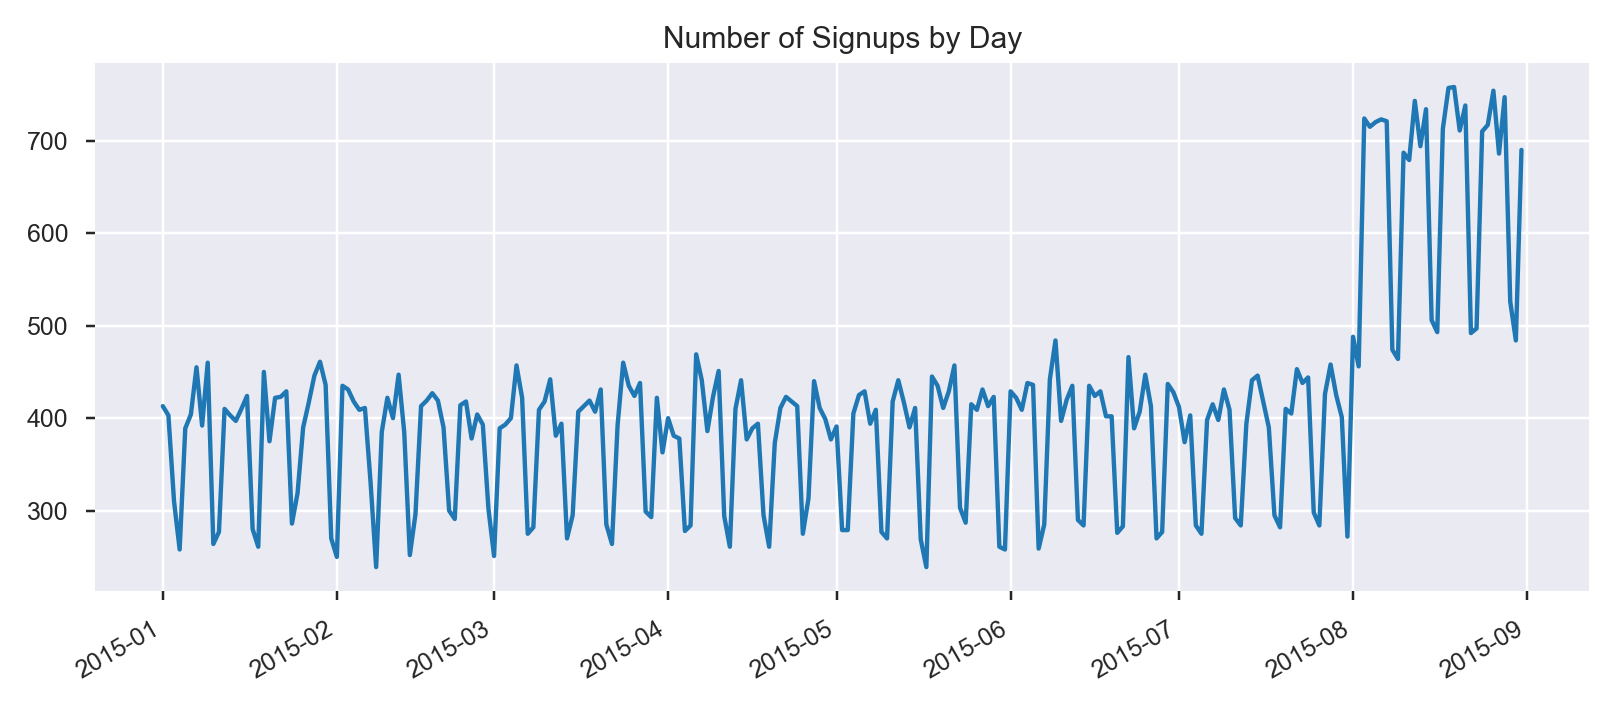

In [13]:
ax = users.signup_date.value_counts().plot(title="Number of Signups by Day")

From above I find there are 100,000 distinct user_id in both test and users datasets, and their merged dataset.

From the merged dataset, there are 50154 users in the test group and 49846 users in the control groups. Data are collected from 2015-08-01 to 2015-08-31, where the number of records for each date fluctuates around 10,000 records per day. Also, it is found 43.4% users are using Chrome, about half of this number of users are using IE or Firefox, even less are using Safari or others. In addition, in this A/B test, 20,001 out of the 100,000 users are first time users. Also, the distribution of the pages_visited values is right-skewed.

Given the users dataset, I generated the plot "Number of Signups by Day". It's easy to see there's periodic up and downs in # of user signups and it is a weekly periodicity. Also we see a surge of signups sstarting from 2015-08, which corresponds to the starting date of the experiment (2015-08-01).

### 3. Questions

#### Part 1. Is the test winning? That is, should 100% of the users see the Recommended Friends feature?

Before generating the test results, we need to first check if the user composition are the same between the test and control groups. Here because I only have the date (of the session), signup_date and browser columns available (in the merged dataset), I will build a decision tree model using these three features to predict the value of "test". 

In [14]:
X = merged[["date", "signup_date", "browser", "first_time_user"]]
X["date"] = X.date.dt.strftime('%Y-%m-%d')
X["signup_date"] = X.signup_date.dt.strftime('%Y-%m-%d')
X = pd.get_dummies(X, drop_first=True)
y = merged["test"]

In [15]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

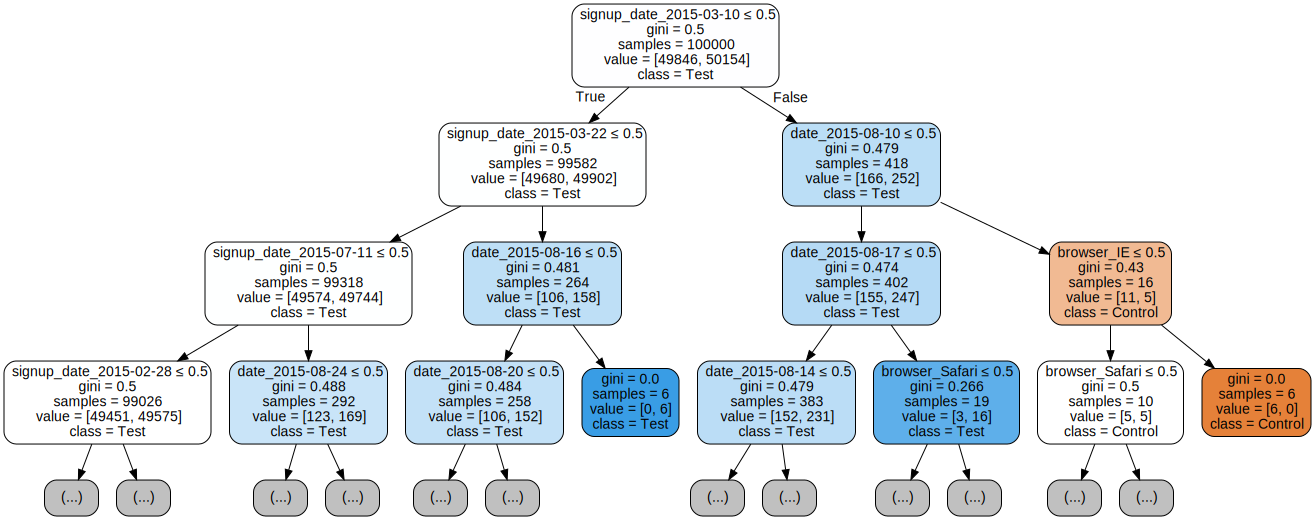

In [16]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None, max_depth=3,
                     feature_names=list(X.columns),  
                     class_names=["Control", "Test"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

The decision tree shows that all the nodes in the first three levels have gini index close to 0.5, meaning there's no feature indentified in the first two layer of nodes that can effectively help to distinguish the treatment level. On the fourth level there are two node with 1 treatment level (one with 6 samples of test class out of decision date_2015-08-16 ≤ 0.5, and one with 6 samples of control class out of decision browser_IE ≤ 0.5) and one node with mostly test class (out of decision date_2015-08-17 ≤ 0.5). However, these 4th layer pure nodes only contain very small number of samples, and the systematic imbalance of test/control splits are not found.

The above finding can be further confirmed by the following plots.

<IPython.core.display.Javascript object>


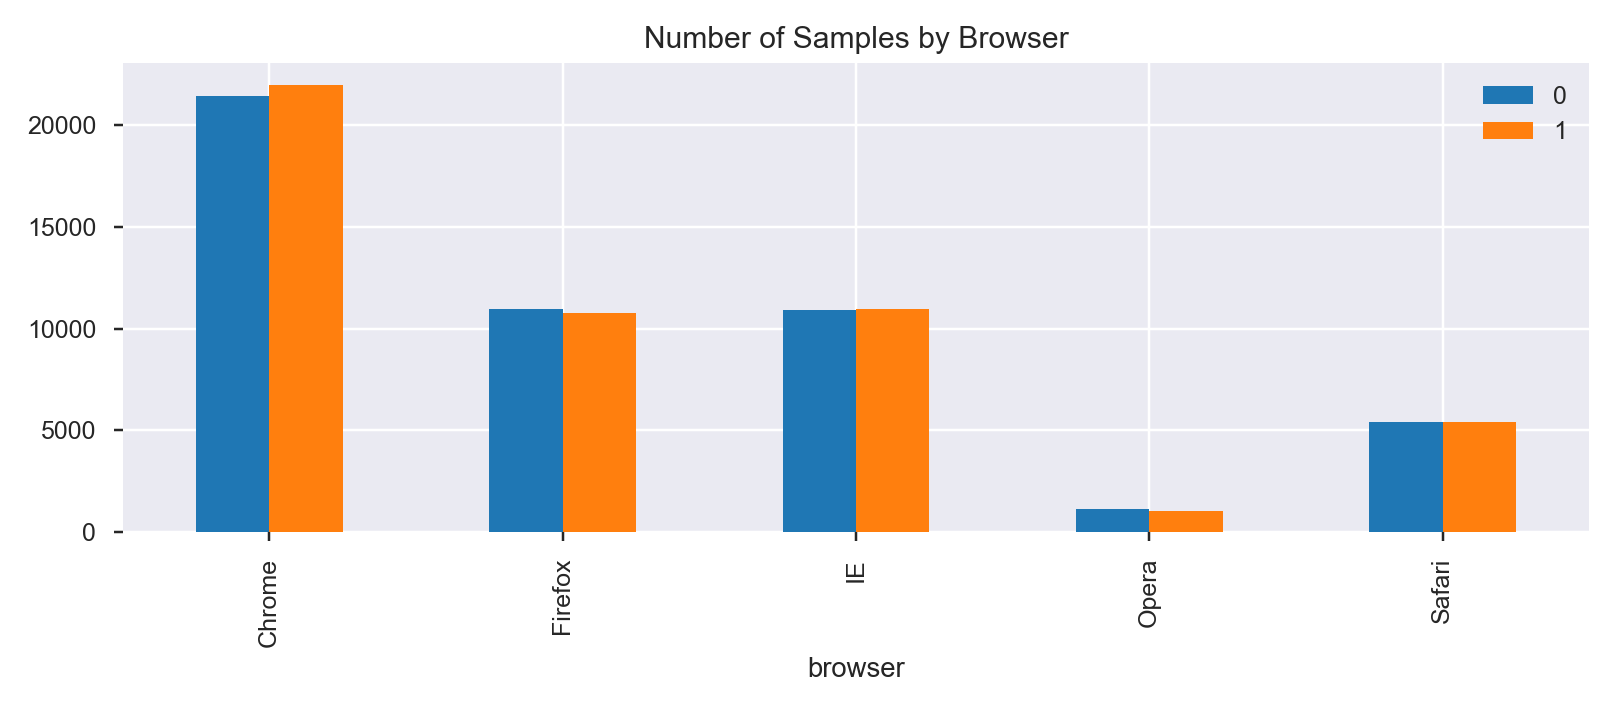

In [17]:
# Plot of Number of Samples by Browser
ax = merged.groupby("browser").apply(lambda x: x.test.value_counts()).unstack()\
.plot.bar(title="Number of Samples by Browser")

<IPython.core.display.Javascript object>


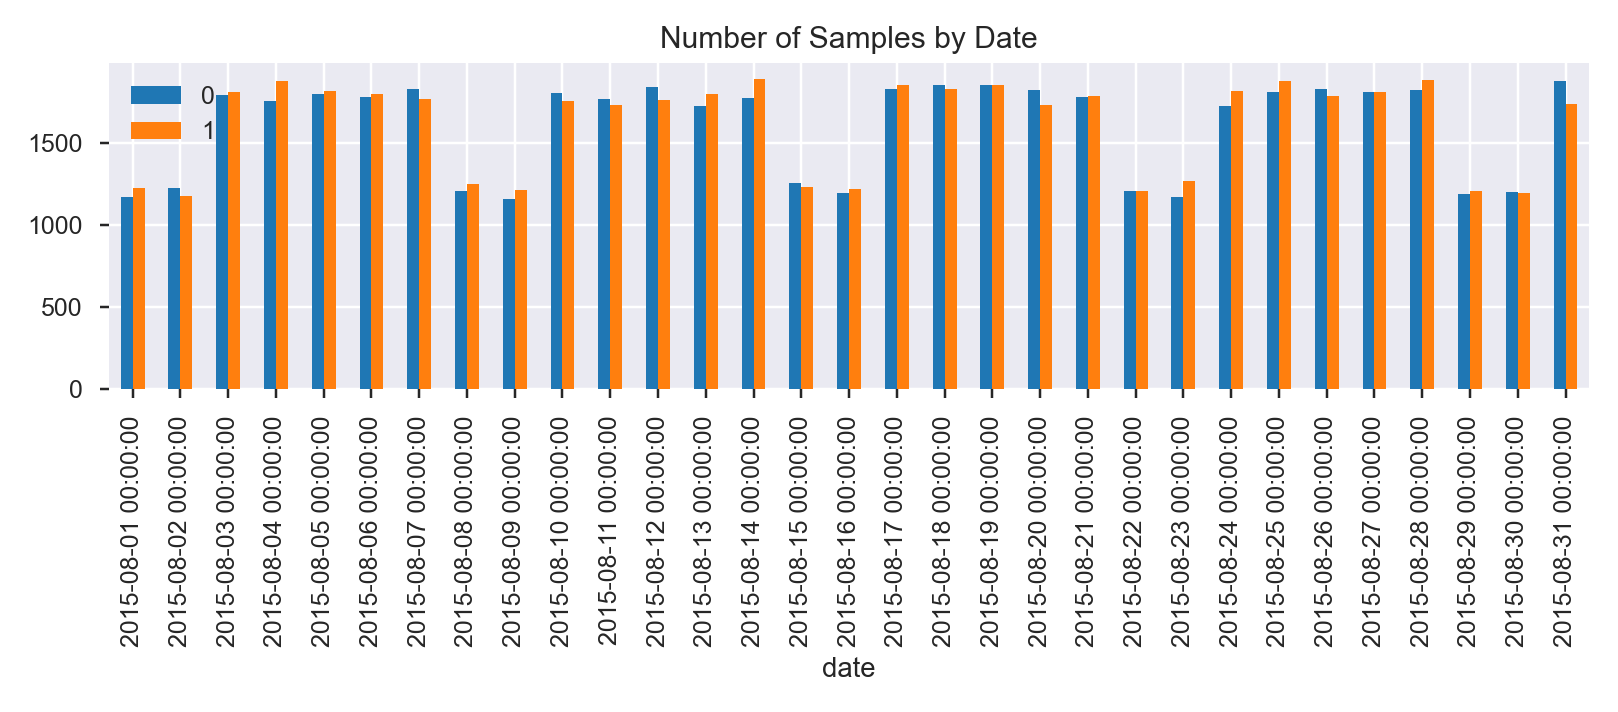

In [18]:
# Plot of Number of Samples by Date
ax = merged.groupby("date").apply(lambda x: x.test.value_counts()).unstack()\
.plot.bar(title="Number of Samples by Date")

<IPython.core.display.Javascript object>


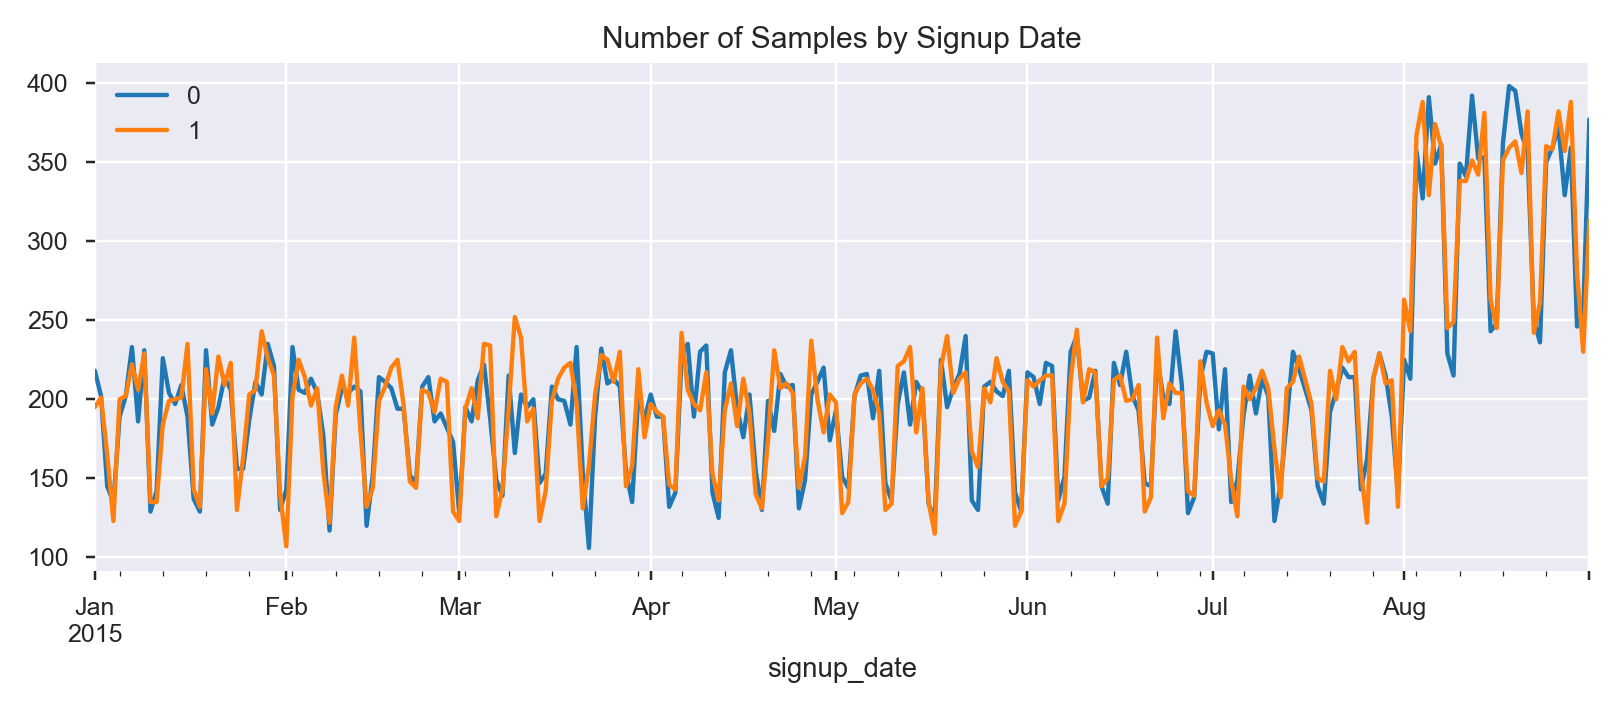

In [19]:
# bar plot is replaced by line plot (for Number of Samples by Signup Date) to avoid overlapping xtick labels.
ax = merged.groupby("signup_date").apply(lambda x: x.test.value_counts()).unstack()\
.plot(title="Number of Samples by Signup Date")

<IPython.core.display.Javascript object>


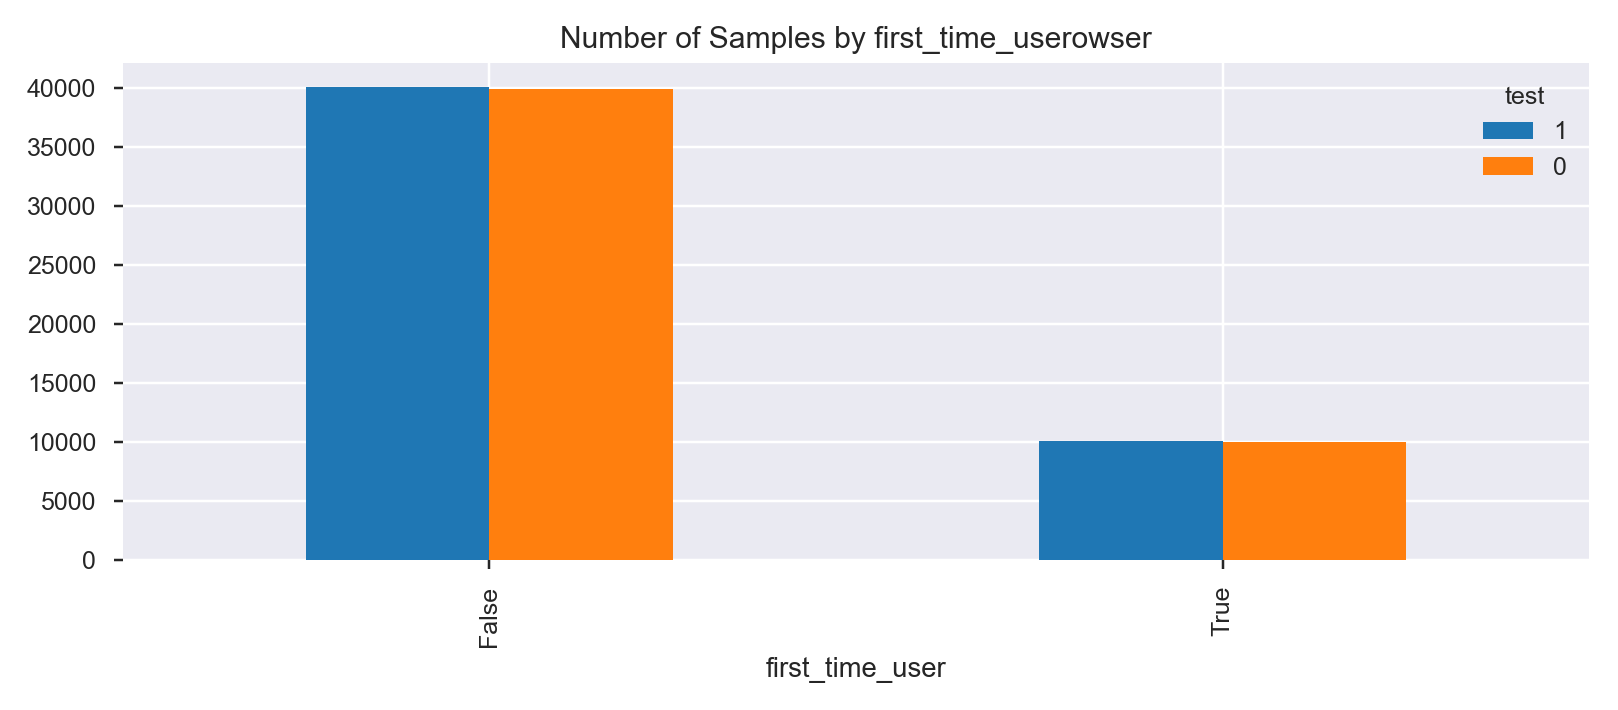

In [20]:
# Plot of Number of Samples by first_time_user
%matplotlib notebook
ax = merged.groupby("first_time_user").apply(lambda x: x.test.value_counts())\
.plot.bar(title="Number of Samples by first_time_userowser")

In [21]:
def test_of_same_proportions(data, label_col, classes, variables):
    """Test to ensure the same demographic composition of the test and control groups, in
    order to avoid the bias as a result of the confounding between the treatment and the 
    demographic property.
    """
    chi2s, ps, decisions = [], [], []
    for variable in variables:
        sizes1 = data[data[label_col]==classes[1]].groupby(variable).size()
        sizes2 = data[data[label_col]==classes[0]].groupby(variable).size()
        obs = pd.concat([sizes1, sizes2], axis=1).dropna().values

        chi2, p, dof, ex = stats.chi2_contingency(obs)
        chi2s.append(chi2)
        ps.append(p)
        decisions.append(False if p < 0.05 else True)
        
#     return chi2, p, dof, ex 
    return pd.DataFrame({"variable":variables, "chi2": chi2s, "p": ps, "H0": decisions})

In [22]:
test_of_same_proportions(merged, "test", ["0", "1"], ["browser", "date", "signup_date", "first_time_user"])

,variable,chi2,p,H0
0,browser,10.998104,0.026585,False
1,date,34.434851,0.263783,True
2,signup_date,274.865431,0.071989,True
3,first_time_user,0.043549,0.834696,True


Now the browser composition is tested to be statistically different between the test and control groups, however, this might be due to the large sample size. I will further investigate this in answers to Question 2. 

In [23]:
def test_of_equal_sizes(data, label_col, classes):
    """Test to ensure same size of test and control groups, in order to maximize the 
    statistical power of the A/B test."""
    n1 = data[data[label_col] == classes[1]].shape[0]
    n2 = data[data[label_col] == classes[0]].shape[0]
    n = n1 + n2
    p = 0.5
    z = (n1 - n * p) / np.sqrt(n * p * (1 - p))
    p = stats.norm.cdf(z) * 2 if z < 0 else (1 - stats.norm.cdf(z)) * 2
    return pd.DataFrame([{"z":z, "p-val":p, "H0": False if p < 0.05 else True}])

test_of_equal_sizes(merged, "test", ["0", "1"])

,z,p-val,H0
0,0.973982,0.330066,True


The above shows the overall split between test and control groups is balanced.

#### A/B test of User Engagement:

In [24]:
def AB_test_two_sample_means(data, label_col, classes, metric_var):
    ctrl_samples = data.loc[data[label_col] == classes[0], metric_var]
    test_samples = data.loc[data[label_col] == classes[1], metric_var]
    ctrl_mean = ctrl_samples.mean()
    test_mean = test_samples.mean()
    test_ctrl_diff = test_mean - ctrl_mean
    t, p = stats.ttest_ind(test_samples, ctrl_samples, equal_var=False)
    
    return pd.Series({"test_size": test_samples.shape[0], "ctrl_size": ctrl_samples.shape[0], 
                      "test_mean": test_mean, "ctrl_mean": ctrl_mean, "test_ctrl_diff": test_ctrl_diff, 
                  "t": t, "p": p, "H0": p>=0.05})
                           
AB_test_two_sample_means(merged, "test", ["0", "1"], "pages_visited")

test_size              50154
ctrl_size              49846
test_mean            4.59969
ctrl_mean            4.60839
test_ctrl_diff   -0.00870091
t                  -0.557112
p                   0.577452
H0                      True
dtype: object

Above is a two-sample t test where variances of means are assumed different between test and control groups. The test results (pvalue=0.5774523171559118) shows there's no evidence that the average number of pages visited is increased after having the 5-friend recommendation feature in newsfeed.

#### Part 2. Is the test performing similarly for all user segments or are there differences among different segments?

In [25]:
ftu = merged.groupby("first_time_user")\
.apply(lambda df: AB_test_two_sample_means(df, "test", ["0", "1"], "pages_visited"))
ftu[ftu.H0==False]

,test_size,ctrl_size,test_mean,ctrl_mean,test_ctrl_diff,t,p,H0
first_time_user,,,,,,,,
True,10045,9956,4.509109,4.628867,-0.119758,-3.131472,0.001742,False


In [26]:
b = merged.groupby("browser")\
.apply(lambda df: AB_test_two_sample_means(df, "test", ["0", "1"], "pages_visited"))
b[b.H0==False]

,test_size,ctrl_size,test_mean,ctrl_mean,test_ctrl_diff,t,p,H0
browser,,,,,,,,
Chrome,21974,21453,4.690680,4.613341,0.077339,3.307123,9.434084e-04,False
Firefox,10786,10972,4.714259,4.600164,0.114095,3.440530,5.817199e-04,False
IE,10974,10906,4.685985,4.598478,0.087507,2.659597,7.829509e-03,False
Opera,1018,1109,0.000000,4.546438,-4.546438,-55.368710,2.252939e-321,False


In [27]:
ftu_b = merged.groupby(["first_time_user", "browser"])\
.apply(lambda df: AB_test_two_sample_means(df, "test", ["0", "1"], "pages_visited"))
ftu_b[ftu_b.H0==False]

test_size  ctrl_size  test_mean  ctrl_mean  \
first_time_user browser                                               
False           Chrome       17525      17092   4.701512   4.607945   
                Firefox       8657       8842   4.757306   4.590590   
                IE            8779       8744   4.721494   4.590576   
                Opera          833        883   0.000000   4.594564   
True            Opera          185        226   0.000000   4.358407   

                         test_ctrl_diff          t              p     H0  
first_time_user browser                                                   
False           Chrome         0.093567   3.685000   2.290889e-04  False  
                Firefox        0.166716   4.629565   3.692901e-06  False  
                IE             0.130918   3.646211   2.669847e-04  False  
                Opera         -4.594564 -49.160170  7.204927e-255  False  
True            Opera         -4.358407 -25.616744   1.222949e-68  False

In [28]:
d = merged.groupby("date")\
.apply(lambda df: AB_test_two_sample_means(df, "test", ["0", "1"], "pages_visited"))
d[d.H0==False]

,test_size,ctrl_size,test_mean,ctrl_mean,test_ctrl_diff,t,p,H0
date,,,,,,,,
2015-08-20,1728,1822,4.696759,4.526894,0.169866,2.038718,0.041554,False


In above, I segmented the users by first_time_user, by browser, by (first_time_user, browser), by date and by signup_date, I found:
* mean pages_visited is significantly smaller in the test group.
* mean pages_visited is significantly bigger in the Chrome, Firefox and IE browsers, and there must be a bug in Opera during the experiment time such that users cannot visit any page.
* mean pages_visited show significant improvement in the test group in only one day.

#### Part 3. If you identified segments that responded differently to the test, can you guess the reason? Would this change your conclusions?

The reason that the segment level test results is different than the A/B test result can be the confonding of the user's own characteristics (browser, date, first_time_user) influencing the pages_visited, in addition to the effect of the 5-friend recommendation. The confounding can happen if 
* there is/are user characteristic(s) that have effect(s) on the outcome and 
* the distribution of such characteristic(s) are different between the test and control groups.

In [29]:
formula = """
pages_visited ~ C(date)+C(browser)+C(first_time_user) + C(browser):C(first_time_user)
"""
model_fit = smf.ols(formula, merged).fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:          pages_visited   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     47.47
Date:                Sun, 11 Oct 2020   Prob (F-statistic):               0.00
Time:                        03:00:41   Log-Likelihood:            -2.3131e+05
No. Observations:              100000   AIC:                         4.627e+05
Df Residuals:                   99960   BIC:                         4.631e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

There's no any variable other than browser Opera that has a siginificant effect on pages_visited, and it was identified that a bug may exist on Opera in Part 2, this will greatly bias the results.

In [30]:
merged2 = merged[merged.browser!="Opera"]

In [31]:
# redo the data sanity checks for the overall test:
check1 = test_of_equal_sizes(merged2, "test", ["0", "1"])
check2 = test_of_same_proportions(merged2, "test", ["0", "1"], ["browser", "date", "signup_date", "first_time_user"])

In [32]:
print(check1)
print(check2)

          z     p-val    H0
0  1.275385  0.202173  True
          variable        chi2         p    H0
0          browser    6.426862  0.092592  True
1             date   37.649413  0.158960  True
2      signup_date  276.479297  0.063206  True
3  first_time_user    0.154095  0.694652  True


The above confirms:
* similar number of samples in test and control groups.
* similar distribution of user characteristics between the test and control groups.

In [33]:
AB_test_two_sample_means(merged2, "test", ["0", "1"], "pages_visited")

test_size               49136
ctrl_size               48737
test_mean             4.69499
ctrl_mean              4.6098
test_ctrl_diff      0.0851858
t                      5.4743
p                 4.40395e-08
H0                      False
dtype: object

The above shows siginificant increase in the mean pages_visisted in the control group. So the previous conclusion of the overall A/B test cannot be trusted, and currently we can report the segment-level results where the Opera browser is not involved. More accurate segment level and overall test results can be created only after the web page rendering issue (but) is fixed for Opera.

With regard to the segment first_time_user=True, I find statistically significant negative effect of treatment (5-friend recommendation) on outcome (average pages_visited). I believe this is because the friend recommendation engine doesn't perform well to recommend real-life friend to new users when there's a lack of data. When new users see recommendation of complete strangers instead of interesting content in the newsfeed, they may find the web app less interesting and thus engage less with the webapp.

In general, I recommend do and report segment level A/B Tests. And the overall A/B test results can be reported only when the test implementation is bug free and the data validity check returns True (see example in the last part of Project 2. Update of the code in class "test_data_validity" is required since now we are doing two sample test of means instead of the two sample test of proportions).